<a href="https://colab.research.google.com/github/Delicheh/github-slideshow/blob/master/GermanDataset_ClusterBasedConsensusMethod.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ClusterBased & Consensus Model Kohonen’s self-organizing maps (SOM)

@misc{riese2019susicode, author = {Riese, Felix~M.}, title = {{SuSi: SUpervised Self-organIzing maps in Python}}, year = {2019}, DOI = {10.5281/zenodo.2609130}, publisher = {Zenodo}, howpublished = {\href{https://doi.org/10.5281/zenodo.2609130}{doi.org/10.5281/zenodo.2609130}} }

In [54]:
pip install susi

In [0]:
# Import Libraries

from sklearn.preprocessing import normalize, minmax_scale, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.feature_selection import SelectFromModel 
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, roc_auc_score, matthews_corrcoef
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm
from sklearn.utils import shuffle
from sklearn.cluster import AgglomerativeClustering, KMeans
import susi
import s3fs
import pandas as pd
import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings(action='ignore')

In [56]:
# Import the Dataset

germanDataset = pd.read_csv ('s3://dissertationdataset/GermanDataset/GermanDataset.csv')
germanDataset = germanDataset.astype('float64')
print(germanDataset.shape)
print(germanDataset.info())
germanDataset.head()

(1000, 21)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 21 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   salary                   1000 non-null   float64
 1   duration                 1000 non-null   float64
 2   creditHistory            1000 non-null   float64
 3   purpose                  1000 non-null   float64
 4   creditAmount             1000 non-null   float64
 5   savingAccount/bonds      1000 non-null   float64
 6   employmentSince          1000 non-null   float64
 7   installmentRate          1000 non-null   float64
 8   personalStatus           1000 non-null   float64
 9   otherDebtors             1000 non-null   float64
 10  presentResidenceSince    1000 non-null   float64
 11  property                 1000 non-null   float64
 12  age                      1000 non-null   float64
 13  otherInstallmentPlan     1000 non-null   float64
 14  housing       

,salary,duration,creditHistory,purpose,creditAmount,savingAccount/bonds,employmentSince,installmentRate,personalStatus,otherDebtors,presentResidenceSince,property,age,otherInstallmentPlan,housing,numberOfExistingCredits,job,maintenance,telephone,foreignWorker,creditStatus
0,1.0,6.0,4.0,3.0,1169.0,5.0,5.0,4.0,3.0,1.0,4.0,1.0,67.0,3.0,2.0,2.0,3.0,1.0,2.0,1.0,1.0
1,2.0,48.0,2.0,3.0,5951.0,1.0,3.0,2.0,2.0,1.0,2.0,1.0,22.0,3.0,2.0,1.0,3.0,1.0,1.0,1.0,2.0
2,4.0,12.0,4.0,6.0,2096.0,1.0,4.0,2.0,3.0,1.0,3.0,1.0,49.0,3.0,2.0,1.0,2.0,2.0,1.0,1.0,1.0
3,1.0,42.0,2.0,2.0,7882.0,1.0,4.0,2.0,3.0,3.0,4.0,2.0,45.0,3.0,3.0,1.0,3.0,2.0,1.0,1.0,1.0
4,1.0,24.0,3.0,0.0,4870.0,1.0,3.0,3.0,3.0,1.0,4.0,4.0,53.0,3.0,3.0,2.0,3.0,2.0,1.0,1.0,2.0


In [0]:
# Encoding the Credit Status (Replace 2 with 0 (0 Bad , 1 Good))

germanDataset['creditStatus'] = germanDataset['creditStatus'].replace(2, 0)

In [58]:
# Finding features with more than 95% missing 

# Define method for calcuating number of missing values
def missing_values(dataframe):
    missingValuesSum = dataframe.isnull().sum()
    missingValuesPercentage = (missingValuesSum * 100) / dataframe.shape[0]
    missingValuesTable = pd.concat([missingValuesSum, missingValuesPercentage], axis=1)
    missingValuesTable = missingValuesTable.rename(columns = {0 : 'Number of Missing Values', 1 : '% of Total'})
    return missingValuesTable

missing_values(germanDataset)

,Number of Missing Values,% of Total
salary,0,0.0
duration,0,0.0
creditHistory,0,0.0
purpose,0,0.0
creditAmount,0,0.0
savingAccount/bonds,0,0.0
employmentSince,0,0.0
installmentRate,0,0.0
personalStatus,0,0.0
otherDebtors,0,0.0


In [59]:
# Finding number of duplicated rows

duplicate_rows = germanDataset[germanDataset.duplicated()]
duplicate_rows.shape

(0, 21)

In [0]:
# Modify the scale of duration, age and continuous Features

continuousFeatures = ['duration', 'creditAmount', 'age', 'installmentRate', 
                      'presentResidenceSince', 'numberOfExistingCredits']
x = germanDataset[continuousFeatures].values
x_scaled = minmax_scale(x)
dfTemp = pd.DataFrame(x_scaled, columns=continuousFeatures, index = germanDataset.index)
germanDataset[continuousFeatures] = dfTemp

## k-means - clustering

In [61]:
#  Clustering

clu = KMeans(n_clusters=5, random_state=42)
clu.fit(germanDataset.iloc[:, :-1].values)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=5, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=42, tol=0.0001, verbose=0)

In [0]:
# Add cluster label as a feature

labels = pd.Series(clu.labels_, index = germanDataset.index)
germanDataset.insert(0,'clusterLabel',labels)

In [63]:
ct = pd.crosstab (germanDataset['clusterLabel'], germanDataset['creditStatus'])
print (ct)

creditStatus  0.0  1.0
clusterLabel          
0              31  165
1              19  169
2              61  106
3              99  126
4              90  134


creditStatus       0.0       1.0
clusterLabel                    
0             0.158163  0.841837
1             0.101064  0.898936
2             0.365269  0.634731
3             0.440000  0.560000
4             0.401786  0.598214


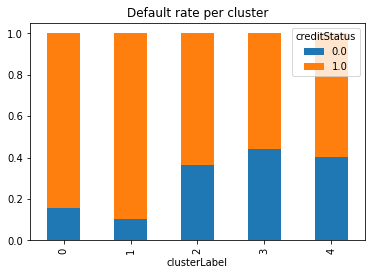

In [64]:
pct = ct.div(ct.sum(1).astype('float'), axis=0)
print (pct)

pct.plot(kind = 'bar', stacked=True, title = 'Default rate per cluster')

In [65]:
# Dataset description 

Desc_Dataset = germanDataset.describe()

# Standard deviation metrics

Desc_Dataset.loc['+3 std'] = Desc_Dataset.loc['mean'] + (Desc_Dataset.loc['std'] * 3)
Desc_Dataset.loc['-3 std'] = Desc_Dataset.loc['mean'] - (Desc_Dataset.loc['std'] * 3)
Desc_Dataset

,clusterLabel,salary,duration,creditHistory,purpose,creditAmount,savingAccount/bonds,employmentSince,installmentRate,personalStatus,otherDebtors,presentResidenceSince,property,age,otherInstallmentPlan,housing,numberOfExistingCredits,job,maintenance,telephone,foreignWorker,creditStatus
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.00000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,2.093000,2.577000,0.248574,2.545000,2.828000,0.166241,2.105000,3.384000,0.657667,2.68200,1.145000,0.615000,2.358000,0.295464,2.675000,1.929000,0.135667,2.904000,1.155000,1.404000,1.037000,0.700000
std,1.444451,1.257638,0.177336,1.083120,2.744439,0.155317,1.580023,1.208306,0.372905,0.70808,0.477706,0.367906,1.050209,0.203133,0.705601,0.531264,0.192551,0.653614,0.362086,0.490943,0.188856,0.458487
min,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,1.00000,1.000000,0.000000,1.000000,0.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000
25%,1.000000,1.000000,0.117647,2.000000,1.000000,0.061379,1.000000,3.000000,0.333333,2.00000,1.000000,0.333333,1.000000,0.142857,3.000000,2.000000,0.000000,3.000000,1.000000,1.000000,1.000000,0.000000
50%,2.000000,2.000000,0.205882,2.000000,2.000000,0.113871,1.000000,3.000000,0.666667,3.00000,1.000000,0.666667,2.000000,0.250000,3.000000,2.000000,0.000000,3.000000,1.000000,1.000000,1.000000,1.000000
75%,3.000000,4.000000,0.294118,4.000000,3.000000,0.204812,3.000000,5.000000,1.000000,3.00000,1.000000,1.000000,3.000000,0.410714,3.000000,2.000000,0.333333,3.000000,1.000000,2.000000,1.000000,1.000000
max,4.000000,4.000000,1.000000,4.000000,10.000000,1.000000,5.000000,5.000000,1.000000,4.00000,3.000000,1.000000,4.000000,1.000000,3.000000,3.000000,1.000000,4.000000,2.000000,2.000000,2.000000,1.000000
+3 std,6.426352,6.349913,0.780580,5.794359,11.061318,0.632193,6.845068,7.008919,1.776381,4.80624,2.578119,1.718718,5.508627,0.904864,4.791803,3.522791,0.713321,4.864842,2.241257,2.876829,1.603569,2.075461
-3 std,-2.240352,-1.195913,-0.283433,-0.704359,-5.405318,-0.299711,-2.635068,-0.240919,-0.461048,0.55776,-0.288119,-0.488718,-0.792627,-0.313936,0.558197,0.335209,-0.441988,0.943158,0.068743,-0.068829,0.470431,-0.675461


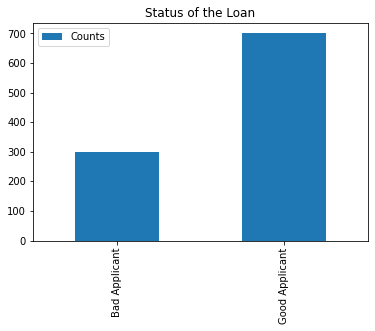

In [66]:
# Visualise (Target variable) Credit Status 

bad = germanDataset[germanDataset['creditStatus'] == 0]['creditStatus'].count()
good = germanDataset[germanDataset['creditStatus'] == 1]['creditStatus'].count()
data = {"Counts":[bad, good] }
applicantStatus = pd.DataFrame(data, index=["Bad Applicant", "Good Applicant"])
applicantStatus.plot(kind='bar', title="Status of the Loan")

In [0]:
# Shuffle rows of the dataframe

germanDataset = shuffle(germanDataset, random_state=42)
germanDataset.reset_index (drop=True , inplace=True)

In [68]:
# Split data into traning 70%  & test 30%

dataset, testDataset = np.split(germanDataset, [int(.7 * len(germanDataset))])
print(dataset.shape)
print(testDataset.shape)

(700, 22)
(300, 22)


In [69]:
# Number of high correlated features (correlation greater than 0.7)

correlation = dataset.corr().abs()
high = correlation.where(np.triu(np.ones(correlation.shape), k=1).astype(np.bool))
highList = [column for column in high.columns if any(high[column] > 0.7)]
print("Number of feature columns with correlation greater than 0.7 :", len(highList))

Number of feature columns with correlation greater than 0.7 : 0


In [70]:
# Features List

featureList = dataset.columns[:-1]
featureList

Index(['clusterLabel', 'salary', 'duration', 'creditHistory', 'purpose',
       'creditAmount', 'savingAccount/bonds', 'employmentSince',
       'installmentRate', 'personalStatus', 'otherDebtors',
       'presentResidenceSince', 'property', 'age', 'otherInstallmentPlan',
       'housing', 'numberOfExistingCredits', 'job', 'maintenance ',
       'telephone', 'foreignWorker'],
      dtype='object')

In [0]:
#  Define Label and Features

X = dataset.drop ('creditStatus' , axis=1)
y = dataset['creditStatus']

In [0]:
# # Grid Search - Hyperparameter Tunning

# param = {"max_depth": np.arange(5, 25), "n_estimators": [100, 200, 300, 400, 500], "min_samples_leaf": np.arange(3, 10)}

# clf = RandomForestClassifier(random_state=42, n_jobs=-1)
# clf_cv = GridSearchCV(clf, param, cv=5) 
# clf_cv.fit(X, y)
# print(clf_cv.best_params_)
# print(clf_cv.best_score_)

# # {'max_depth': 12, 'min_samples_leaf': 5, 'n_estimators': 300}

In [73]:
# Create a random forest classifier
clf = RandomForestClassifier(n_estimators=300, random_state=42, max_depth=12, min_samples_leaf=5, n_jobs=-1)

# Train the classifier
clf.fit(X, y)

# Print the name and gini importance of each feature
for feature in zip(featureList , clf.feature_importances_):
    print(feature)

('clusterLabel', 0.09987273942462618)
('salary', 0.15323220416909855)
('duration', 0.10590160870065526)
('creditHistory', 0.057772348621793146)
('purpose', 0.04353386805148011)
('creditAmount', 0.12401312133577466)
('savingAccount/bonds', 0.04619967737580227)
('employmentSince', 0.04208671992177451)
('installmentRate', 0.035030759215971666)
('personalStatus', 0.03752283499320414)
('otherDebtors', 0.009994330611920227)
('presentResidenceSince', 0.030632445646447133)
('property', 0.033310101423589686)
('age', 0.0839392077525927)
('otherInstallmentPlan', 0.028324449081765683)
('housing', 0.017361671854375562)
('numberOfExistingCredits', 0.011521660354744057)
('job', 0.016116465552817698)
('maintenance ', 0.00820504531959857)
('telephone', 0.013305590830805404)
('foreignWorker', 0.0021231497611628692)


## 1 - Logistic Regression

In [74]:
# Calcuate Feature Importance
# Create a random forest classifier feature selection
clf = RandomForestClassifier(n_estimators=100, random_state=42, max_depth=15, min_samples_leaf=3, n_jobs=-1)

# Train the classifier
clf.fit(X, y)

# Create a selector object to identify features that have gini importance greater than # 0.04 (LR)
sfmLR = SelectFromModel(clf, threshold = 0.04)

# Train the selector
sfmLR.fit(X, y)

# Print the selected features
numberOfSelectedFeatures = 0
for featureListIndex in sfmLR.get_support(indices=True):
    print(featureList[featureListIndex])
    numberOfSelectedFeatures = numberOfSelectedFeatures + 1

print('-'*100)
print("Number of selected featurs: ", numberOfSelectedFeatures)

# Define Label and Features for testDataset
XX = testDataset.drop('creditStatus', axis=1)
yy = testDataset['creditStatus']

# Transform the data to create a new dataset containing only the selected features
# Apply the transform to the training X and test X data.
X_important_train = sfmLR.transform(X)
XX_important = sfmLR.transform(XX)

clusterLabel
salary
duration
creditHistory
purpose
creditAmount
savingAccount/bonds
employmentSince
installmentRate
age
----------------------------------------------------------------------------------------------------
Number of selected featurs:  10


Accuracy of Test set :  0.8066666666666666
----------------------------------------------------------------------------------------------------
Cross validation - Accuracy of Test set :  0.7666666666666667
----------------------------------------------------------------------------------------------------
Confusion Matrix:
[[193  15]
 [ 43  49]]
Classification Report:
              precision    recall  f1-score   support

         0.0       0.77      0.53      0.63        92
         1.0       0.82      0.93      0.87       208

    accuracy                           0.81       300
   macro avg       0.79      0.73      0.75       300
weighted avg       0.80      0.81      0.80       300

----------------------------------------------------------------------------------------------------
Normalized Confusion Matrix:
          Good (1)   Bad (0)
Good (1)  0.817797  0.234375
Bad (0)   0.182203  0.765625
-------------------------------------------------------------------------------------

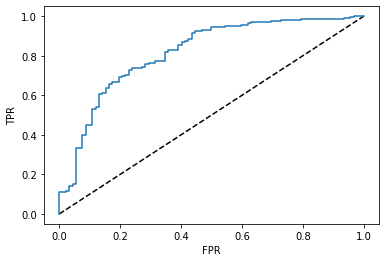

AUC of Test set :  0.8162102842809364
MCC of Test set :  0.5183259100193276


In [75]:
# Create a new Logistic Regression classifier for the selected features
LR_clf_important = LogisticRegression(random_state=42)

# Train the new classifier on the new dataset containing the selected features
LR_clf_important.fit(X_important_train, y)

# Apply The Full Featured Classifier To The Test Data
yy_pred = LR_clf_important.predict(XX_important)

# View The Accuracy Of Selected Features
print("Accuracy of Test set : ",accuracy_score(yy, yy_pred))
print('-'*100)
      
#  Cross Validation Score
cv_scores = cross_val_score(LR_clf_important, XX, yy, cv=5)
print("Cross validation - Accuracy of Test set : ", np.mean(cv_scores))
print('-'*100)
      
# Confusion Matrix
cm = confusion_matrix(yy, yy_pred, [1, 0])
print("Confusion Matrix:")
print(cm)
print("Classification Report:")
print(classification_report(yy, yy_pred))
print('-'*100)

# Normalisation Confusion Matrix - Type I and II error
cm = normalize(cm,norm='l1',axis=0)
cm_df = pd.DataFrame(cm, columns=['Good (1)', 'Bad (0)'], index=['Good (1)', 'Bad (0)'])
print("Normalized Confusion Matrix:")
print(cm_df)
print('-'*100)
      
# The ROC Curve
yy_pred_prob = LR_clf_important.predict_proba(XX_important)[:,1]
fpr, tpr, thresholds = roc_curve(yy, yy_pred_prob)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr,tpr)
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.show()
      
# AUC Area under the roc curve 
print("AUC of Test set : ",roc_auc_score(yy, yy_pred_prob))
      
# Matthews Correlation Coefficient
print("MCC of Test set : ",matthews_corrcoef(yy, yy_pred))

In [0]:
LRTest = LR_clf_important.predict(XX_important)
LR = LR_clf_important.predict(X_important_train)

## 2 - ANN

In [77]:
# Calcuate Feature Importance
# Create a random forest classifier feature selection
clf = RandomForestClassifier(n_estimators=100, random_state=42, max_depth=15, min_samples_leaf=3, n_jobs=-1)

# Train the classifier
clf.fit(X, y)

# Create a selector object to identify features that have gini importance greater than # 0.03 (ANN)
sfmANN = SelectFromModel(clf, threshold = 0.03)

# Train the selector
sfmANN.fit(X, y)

# Print the selected features
numberOfSelectedFeatures = 0
for featureListIndex in sfmANN.get_support(indices=True):
    print(featureList[featureListIndex])
    numberOfSelectedFeatures = numberOfSelectedFeatures + 1

print('-'*100)
print("Number of selected featurs: ", numberOfSelectedFeatures)

# Define Label and Features for testDataset
XX = testDataset.drop('creditStatus', axis=1)
yy = testDataset['creditStatus']

# Transform the data to create a new dataset containing only the selected features
# Apply the transform to the training X and test X data.
X_important_train = sfmANN.transform(X)
XX_important = sfmANN.transform(XX)

clusterLabel
salary
duration
creditHistory
purpose
creditAmount
savingAccount/bonds
employmentSince
installmentRate
personalStatus
presentResidenceSince
property
age
----------------------------------------------------------------------------------------------------
Number of selected featurs:  13


In [0]:
# # Grid Search - Hyperparameter Tunning

# param = {'hidden_layer_sizes': np.arange(10,50) , "alpha": [0.001, 0.01, 0.1, 1]}

# clf = MLPClassifier(random_state=42)
# clf_cv = GridSearchCV(clf, param, cv=5) 
# clf_cv.fit(X_important_train, y)
# print(clf_cv.best_params_)
# print(clf_cv.best_score_)

# # {'alpha': 0.1, 'hidden_layer_sizes': 37}

Accuracy of Test set :  0.79
----------------------------------------------------------------------------------------------------
Cross validation - Accuracy of Test set :  0.8
----------------------------------------------------------------------------------------------------
Confusion Matrix:
[[186  22]
 [ 41  51]]
Classification Report:
              precision    recall  f1-score   support

         0.0       0.70      0.55      0.62        92
         1.0       0.82      0.89      0.86       208

    accuracy                           0.79       300
   macro avg       0.76      0.72      0.74       300
weighted avg       0.78      0.79      0.78       300

----------------------------------------------------------------------------------------------------
Normalized Confusion Matrix:
          Good (1)  Bad (0)
Good (1)  0.819383  0.30137
Bad (0)   0.180617  0.69863
----------------------------------------------------------------------------------------------------


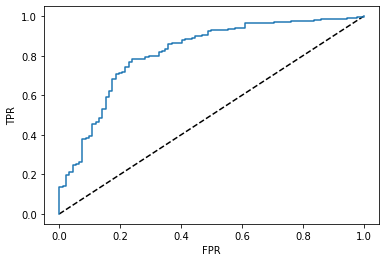

AUC of Test set :  0.8147470735785953
MCC of Test set :  0.4820474270612345


In [79]:
# Create a new MLP classifier for the selected features
ANN_clf_important = MLPClassifier(alpha = 0.1, hidden_layer_sizes = (37) ,random_state = 42)

# Train the new classifier on the new dataset containing the selected features
ANN_clf_important.fit(X_important_train, y)

# Apply The Full Featured Classifier To The Test Data
yy_pred = ANN_clf_important.predict(XX_important)

# View The Accuracy Of Selected Features
print("Accuracy of Test set : ",accuracy_score(yy, yy_pred))
print('-'*100)
      
#  Cross Validation Score
cv_scores = cross_val_score(ANN_clf_important, XX, yy, cv=5)
print("Cross validation - Accuracy of Test set : ", np.mean(cv_scores))
print('-'*100)
      
# Confusion Matrix
cm = confusion_matrix(yy, yy_pred, [1, 0])
print("Confusion Matrix:")
print(cm)
print("Classification Report:")
print(classification_report(yy, yy_pred))
print('-'*100)

# Normalisation Confusion Matrix - Type I and II error
cm = normalize(cm,norm='l1',axis=0)
cm_df = pd.DataFrame(cm, columns=['Good (1)', 'Bad (0)'], index=['Good (1)', 'Bad (0)'])
print("Normalized Confusion Matrix:")
print(cm_df)
print('-'*100)
      
# The ROC Curve
yy_pred_prob = ANN_clf_important.predict_proba(XX_important)[:,1]
fpr, tpr, thresholds = roc_curve(yy, yy_pred_prob)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr,tpr)
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.show()
      
# AUC Area under the roc curve 
print("AUC of Test set : ",roc_auc_score(yy, yy_pred_prob))
      
# Matthews Correlation Coefficient
print("MCC of Test set : ",matthews_corrcoef(yy, yy_pred))

In [0]:
ANNTest = ANN_clf_important.predict(XX_important)
ANN = ANN_clf_important.predict(X_important_train)

## 3 - Decision Trees

In [81]:
# Calcuate Feature Importance
# Create a random forest classifier feature selection
clf = RandomForestClassifier(n_estimators=100, random_state=42, max_depth=15, min_samples_leaf=3, n_jobs=-1)

# Train the classifier
clf.fit(X, y)

# Create a selector object to identify features that have gini importance greater than # 0.05 (DT)
sfmDT = SelectFromModel(clf, threshold = 0.05)

# Train the selector
sfmDT.fit(X, y)

# Print the selected features
numberOfSelectedFeatures = 0
for featureListIndex in sfmDT.get_support(indices=True):
    print(featureList[featureListIndex])
    numberOfSelectedFeatures = numberOfSelectedFeatures + 1

print('-'*100)
print("Number of selected featurs: ", numberOfSelectedFeatures)

# Define Label and Features for testDataset
XX = testDataset.drop('creditStatus', axis=1)
yy = testDataset['creditStatus']

# Transform the data to create a new dataset containing only the selected features
# Apply the transform to the training X and test X data.
X_important_train = sfmDT.transform(X)
XX_important = sfmDT.transform(XX)

clusterLabel
salary
duration
creditHistory
creditAmount
age
----------------------------------------------------------------------------------------------------
Number of selected featurs:  6


In [0]:
# # Grid Search - Hyperparameter Tunning

# param = {'min_samples_split': np.arange (5, 20), 'max_depth': np.arange(5, 15)}

# clf = DecisionTreeClassifier(random_state = 42)
# clf_cv = GridSearchCV(clf, param, cv=5) 
# clf_cv.fit(X_important_train, y)
# print(clf_cv.best_params_)
# print(clf_cv.best_score_)

# # {'max_depth': 5, 'min_samples_split': 5}

Accuracy of Test set :  0.7066666666666667
----------------------------------------------------------------------------------------------------
Cross validation - Accuracy of Test set :  0.7
----------------------------------------------------------------------------------------------------
Confusion Matrix:
[[170  38]
 [ 50  42]]
Classification Report:
              precision    recall  f1-score   support

         0.0       0.53      0.46      0.49        92
         1.0       0.77      0.82      0.79       208

    accuracy                           0.71       300
   macro avg       0.65      0.64      0.64       300
weighted avg       0.70      0.71      0.70       300

----------------------------------------------------------------------------------------------------
Normalized Confusion Matrix:
          Good (1)  Bad (0)
Good (1)  0.772727    0.475
Bad (0)   0.227273    0.525
----------------------------------------------------------------------------------------------------


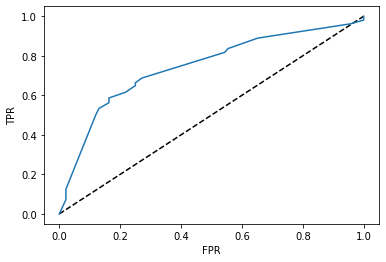

AUC of Test set :  0.7445652173913043
MCC of Test set :  0.2855284395897076


In [83]:
# Create a new decision tree classifier for the selected features
DT_clf_important = DecisionTreeClassifier(min_samples_split = 5, random_state = 42, max_depth = 5)

# Train the new classifier on the new dataset containing the selected features
DT_clf_important.fit(X_important_train, y)

# Apply The Full Featured Classifier To The Test Data
yy_pred = DT_clf_important.predict(XX_important)

# View The Accuracy Of Selected Features
print("Accuracy of Test set : ",accuracy_score(yy, yy_pred))
print('-'*100)
      
#  Cross Validation Score
cv_scores = cross_val_score(DT_clf_important, XX, yy, cv=5)
print("Cross validation - Accuracy of Test set : ", np.mean(cv_scores))
print('-'*100)
      
# Confusion Matrix
cm = confusion_matrix(yy, yy_pred, [1, 0])
print("Confusion Matrix:")
print(cm)
print("Classification Report:")
print(classification_report(yy, yy_pred))
print('-'*100)

# Normalisation Confusion Matrix - Type I and II error
cm = normalize(cm,norm='l1',axis=0)
cm_df = pd.DataFrame(cm, columns=['Good (1)', 'Bad (0)'], index=['Good (1)', 'Bad (0)'])
print("Normalized Confusion Matrix:")
print(cm_df)
print('-'*100)
      
# The ROC Curve
yy_pred_prob = DT_clf_important.predict_proba(XX_important)[:,1]
fpr, tpr, thresholds = roc_curve(yy, yy_pred_prob)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr,tpr)
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.show()
      
# AUC Area under the roc curve 
print("AUC of Test set : ",roc_auc_score(yy, yy_pred_prob))
      
# Matthews Correlation Coefficient
print("MCC of Test set : ",matthews_corrcoef(yy, yy_pred))

In [0]:
DTTest = DT_clf_important.predict(XX_important)
DT = DT_clf_important.predict(X_important_train)

## 4 - Gradient Boosting Decision Trees 

In [85]:
# Calcuate Feature Importance
# Create a random forest classifier feature selection
clf = RandomForestClassifier(n_estimators=100, random_state=42, max_depth=15, min_samples_leaf=3, n_jobs=-1)

# Train the classifier
clf.fit(X, y)

# Create a selector object to identify features that have gini importance greater than # 0.01 (GBDT)
sfmGBDT = SelectFromModel(clf, threshold = 0.01)

# Train the selector
sfmGBDT.fit(X, y)

# Print the selected features
numberOfSelectedFeatures = 0
for featureListIndex in sfmGBDT.get_support(indices=True):
    print(featureList[featureListIndex])
    numberOfSelectedFeatures = numberOfSelectedFeatures + 1

print('-'*100)
print("Number of selected featurs: ", numberOfSelectedFeatures)

# Define Label and Features for testDataset
XX = testDataset.drop('creditStatus', axis=1)
yy = testDataset['creditStatus']

# Transform the data to create a new dataset containing only the selected features
# Apply the transform to the training X and test X data.
X_important_train = sfmGBDT.transform(X)
XX_important = sfmGBDT.transform(XX)

clusterLabel
salary
duration
creditHistory
purpose
creditAmount
savingAccount/bonds
employmentSince
installmentRate
personalStatus
otherDebtors
presentResidenceSince
property
age
otherInstallmentPlan
housing
numberOfExistingCredits
job
maintenance 
telephone
----------------------------------------------------------------------------------------------------
Number of selected featurs:  20


In [0]:
# # Grid Search - Hyperparameter Tunning

# param = {"max_depth": np.arange(5, 25), "n_estimators": [100, 200, 300, 400, 500], "learning_rate": [0.001, 0.01, 0.1, 1]}

# clf = GradientBoostingClassifier(random_state=42)
# clf_cv = GridSearchCV(clf, param, cv=5) 
# clf_cv.fit(X_important_train, y)
# print(clf_cv.best_params_)
# print(clf_cv.best_score_)

# # {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100}

Accuracy of Test set :  0.7633333333333333
----------------------------------------------------------------------------------------------------
Cross validation - Accuracy of Test set :  0.7666666666666667
----------------------------------------------------------------------------------------------------
Confusion Matrix:
[[177  31]
 [ 40  52]]
Classification Report:
              precision    recall  f1-score   support

         0.0       0.63      0.57      0.59        92
         1.0       0.82      0.85      0.83       208

    accuracy                           0.76       300
   macro avg       0.72      0.71      0.71       300
weighted avg       0.76      0.76      0.76       300

----------------------------------------------------------------------------------------------------
Normalized Confusion Matrix:
          Good (1)   Bad (0)
Good (1)  0.815668  0.373494
Bad (0)   0.184332  0.626506
-------------------------------------------------------------------------------------

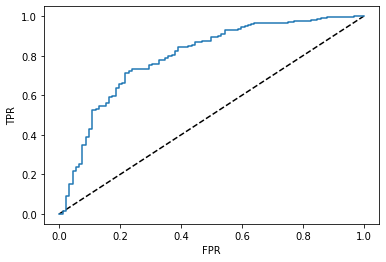

AUC of Test set :  0.7955685618729097
MCC of Test set :  0.42897971572700266


In [87]:
# Create a new GBDT classifier for the selected features
GBDT_clf_important = GradientBoostingClassifier(learning_rate=0.1, max_depth=5, n_estimators=100, random_state=42)

# Train the new classifier on the new dataset containing the selected features
GBDT_clf_important.fit(X_important_train, y)

# Apply The Full Featured Classifier To The Test Data
yy_pred = GBDT_clf_important.predict(XX_important)

# View The Accuracy Of Selected Features
print("Accuracy of Test set : ",accuracy_score(yy, yy_pred))
print('-'*100)
      
#  Cross Validation Score
cv_scores = cross_val_score(GBDT_clf_important, XX, yy, cv=5)
print("Cross validation - Accuracy of Test set : ", np.mean(cv_scores))
print('-'*100)
      
# Confusion Matrix
cm = confusion_matrix(yy, yy_pred, [1, 0])
print("Confusion Matrix:")
print(cm)
print("Classification Report:")
print(classification_report(yy, yy_pred))
print('-'*100)

# Normalisation Confusion Matrix - Type I and II error
cm = normalize(cm,norm='l1',axis=0)
cm_df = pd.DataFrame(cm, columns=['Good (1)', 'Bad (0)'], index=['Good (1)', 'Bad (0)'])
print("Normalized Confusion Matrix:")
print(cm_df)
print('-'*100)
      
# The ROC Curve
yy_pred_prob = GBDT_clf_important.predict_proba(XX_important)[:,1]
fpr, tpr, thresholds = roc_curve(yy, yy_pred_prob)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr,tpr)
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.show()
      
# AUC Area under the roc curve 
print("AUC of Test set : ",roc_auc_score(yy, yy_pred_prob))
      
# Matthews Correlation Coefficient
print("MCC of Test set : ",matthews_corrcoef(yy, yy_pred))

In [0]:
GBDTTest = GBDT_clf_important.predict(XX_important)
GBDT = GBDT_clf_important.predict(X_important_train)

## 5 - kNN

In [89]:
# Calcuate Feature Importance
# Create a random forest classifier feature selection
clf = RandomForestClassifier(n_estimators=100, random_state=42, max_depth=15, min_samples_leaf=3, n_jobs=-1)

# Train the classifier
clf.fit(X, y)

# Create a selector object to identify features that have gini importance greater than # 0.045 (kNN)
sfmKNN = SelectFromModel(clf, threshold = 0.045)

# Train the selector
sfmKNN.fit(X, y)

# Print the selected features
numberOfSelectedFeatures = 0
for featureListIndex in sfmKNN.get_support(indices=True):
    print(featureList[featureListIndex])
    numberOfSelectedFeatures = numberOfSelectedFeatures + 1

print('-'*100)
print("Number of selected featurs: ", numberOfSelectedFeatures)

# Define Label and Features for testDataset
XX = testDataset.drop('creditStatus', axis=1)
yy = testDataset['creditStatus']

# Transform the data to create a new dataset containing only the selected features
# Apply the transform to the training X and test X data.
X_important_train = sfmKNN.transform(X)
XX_important = sfmKNN.transform(XX)

clusterLabel
salary
duration
creditHistory
purpose
creditAmount
employmentSince
age
----------------------------------------------------------------------------------------------------
Number of selected featurs:  8


In [0]:
# # Grid Search - Hyperparameter Tunning

# param = {'n_neighbors': np.arange(3, 10)}

# clf = KNeighborsClassifier()
# clf_cv = GridSearchCV(clf, param, cv=5) 
# clf_cv.fit(X_important_train, y)
# print(clf_cv.best_params_)
# print(clf_cv.best_score_)

# # {'n_neighbors': 7}

Accuracy of Test set :  0.74
----------------------------------------------------------------------------------------------------
Cross validation - Accuracy of Test set :  0.7366666666666666
----------------------------------------------------------------------------------------------------
Confusion Matrix:
[[184  24]
 [ 54  38]]
Classification Report:
              precision    recall  f1-score   support

         0.0       0.61      0.41      0.49        92
         1.0       0.77      0.88      0.83       208

    accuracy                           0.74       300
   macro avg       0.69      0.65      0.66       300
weighted avg       0.72      0.74      0.72       300

----------------------------------------------------------------------------------------------------
Normalized Confusion Matrix:
          Good (1)   Bad (0)
Good (1)  0.773109  0.387097
Bad (0)   0.226891  0.612903
---------------------------------------------------------------------------------------------------

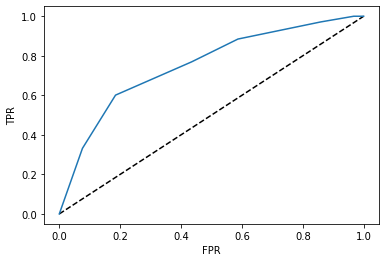

AUC of Test set :  0.752299331103679
MCC of Test set :  0.33896907341023713


In [91]:
# Create a new kNN classifier for the selected features
KNN_clf_important = KNeighborsClassifier(n_neighbors=7)

# Train the new classifier on the new dataset containing the selected features
KNN_clf_important.fit(X_important_train, y)

# Apply The Full Featured Classifier To The Test Data
yy_pred = KNN_clf_important.predict(XX_important)

# View The Accuracy Of Selected Features
print("Accuracy of Test set : ",accuracy_score(yy, yy_pred))
print('-'*100)
      
#  Cross Validation Score
cv_scores = cross_val_score(KNN_clf_important, XX, yy, cv=5)
print("Cross validation - Accuracy of Test set : ", np.mean(cv_scores))
print('-'*100)
      
# Confusion Matrix
cm = confusion_matrix(yy, yy_pred, [1, 0])
print("Confusion Matrix:")
print(cm)
print("Classification Report:")
print(classification_report(yy, yy_pred))
print('-'*100)

# Normalisation Confusion Matrix - Type I and II error
cm = normalize(cm,norm='l1',axis=0)
cm_df = pd.DataFrame(cm, columns=['Good (1)', 'Bad (0)'], index=['Good (1)', 'Bad (0)'])
print("Normalized Confusion Matrix:")
print(cm_df)
print('-'*100)
      
# The ROC Curve
yy_pred_prob = KNN_clf_important.predict_proba(XX_important)[:,1]
fpr, tpr, thresholds = roc_curve(yy, yy_pred_prob)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr,tpr)
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.show()
      
# AUC Area under the roc curve 
print("AUC of Test set : ",roc_auc_score(yy, yy_pred_prob))
      
# Matthews Correlation Coefficient
print("MCC of Test set : ",matthews_corrcoef(yy, yy_pred))

In [0]:
KNNTest = KNN_clf_important.predict(XX_important)
KNN = KNN_clf_important.predict(X_important_train)

## 6 - Random Forest

In [93]:
# Calcuate Feature Importance
# Create a random forest classifier feature selection
clf = RandomForestClassifier(n_estimators=100, random_state=42, max_depth=15, min_samples_leaf=3, n_jobs=-1)

# Train the classifier
clf.fit(X, y)

# Create a selector object to identify features that have gini importance greater than # 0.02 (RF) 
sfmRF = SelectFromModel(clf, threshold = 0.02)

# Train the selector
sfmRF.fit(X, y)

# Print the selected features
numberOfSelectedFeatures = 0
for featureListIndex in sfmRF.get_support(indices=True):
    print(featureList[featureListIndex])
    numberOfSelectedFeatures = numberOfSelectedFeatures + 1

print('-'*100)
print("Number of selected featurs: ", numberOfSelectedFeatures)

# Define Label and Features for testDataset
XX = testDataset.drop('creditStatus', axis=1)
yy = testDataset['creditStatus']

# Transform the data to create a new dataset containing only the selected features
# Apply the transform to the training X and test X data.
X_important_train = sfmRF.transform(X)
XX_important = sfmRF.transform(XX)

clusterLabel
salary
duration
creditHistory
purpose
creditAmount
savingAccount/bonds
employmentSince
installmentRate
personalStatus
presentResidenceSince
property
age
otherInstallmentPlan
housing
job
----------------------------------------------------------------------------------------------------
Number of selected featurs:  16


In [0]:
# # Grid Search - Hyperparameter Tunning

# param = {"max_depth": np.arange(5, 25), "n_estimators": [100, 200, 300, 400, 500], "min_samples_leaf": np.arange(3, 10)}

# clf = RandomForestClassifier(random_state=42)
# clf_cv = GridSearchCV(clf, param, cv=5) 
# clf_cv.fit(X_important_train, y)
# print(clf_cv.best_params_)
# print(clf_cv.best_score_)

# # {'max_depth': 11, 'min_samples_leaf': 3, 'n_estimators': 300}

Accuracy of Test set :  0.7966666666666666
----------------------------------------------------------------------------------------------------
Cross validation - Accuracy of Test set :  0.7833333333333334
----------------------------------------------------------------------------------------------------
Confusion Matrix:
[[193  15]
 [ 46  46]]
Classification Report:
              precision    recall  f1-score   support

         0.0       0.75      0.50      0.60        92
         1.0       0.81      0.93      0.86       208

    accuracy                           0.80       300
   macro avg       0.78      0.71      0.73       300
weighted avg       0.79      0.80      0.78       300

----------------------------------------------------------------------------------------------------
Normalized Confusion Matrix:
          Good (1)   Bad (0)
Good (1)  0.807531  0.245902
Bad (0)   0.192469  0.754098
-------------------------------------------------------------------------------------

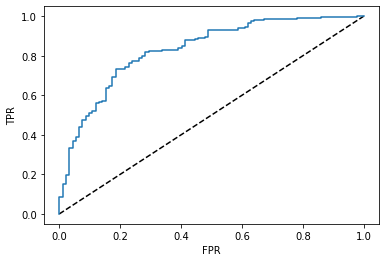

AUC of Test set :  0.8308946488294315
MCC of Test set :  0.49021701917752486


In [95]:
# Create a new random forest classifier for the selected features
RF_clf_important = RandomForestClassifier(n_estimators=300, random_state=42, max_depth=11, min_samples_leaf=3, n_jobs=-1)

# Train the new classifier on the new dataset containing the selected features
RF_clf_important.fit(X_important_train, y)

# Apply The Full Featured Classifier To The Test Data
yy_pred = RF_clf_important.predict(XX_important)

# View The Accuracy Of Selected Features
print("Accuracy of Test set : ",accuracy_score(yy, yy_pred))
print('-'*100)
      
#  Cross Validation Score
cv_scores = cross_val_score(RF_clf_important, XX, yy, cv=5)
print("Cross validation - Accuracy of Test set : ", np.mean(cv_scores))
print('-'*100)
      
# Confusion Matrix
cm = confusion_matrix(yy, yy_pred, [1, 0])
print("Confusion Matrix:")
print(cm)
print("Classification Report:")
print(classification_report(yy, yy_pred))
print('-'*100)

# Normalisation Confusion Matrix - Type I and II error
cm = normalize(cm,norm='l1',axis=0)
cm_df = pd.DataFrame(cm, columns=['Good (1)', 'Bad (0)'], index=['Good (1)', 'Bad (0)'])
print("Normalized Confusion Matrix:")
print(cm_df)
print('-'*100)
      
# The ROC Curve
yy_pred_prob = RF_clf_important.predict_proba(XX_important)[:,1]
fpr, tpr, thresholds = roc_curve(yy, yy_pred_prob)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr,tpr)
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.show()
      
# AUC Area under the roc curve 
print("AUC of Test set : ",roc_auc_score(yy, yy_pred_prob))
      
# Matthews Correlation Coefficient
print("MCC of Test set : ",matthews_corrcoef(yy, yy_pred))

In [0]:
RFTest = RF_clf_important.predict(XX_important)
RF = RF_clf_important.predict(X_important_train)

## 7 - SVM

In [97]:
# Calcuate Feature Importance
# Create a random forest classifier feature selection
clf = RandomForestClassifier(n_estimators=100, random_state=42, max_depth=15, min_samples_leaf=3, n_jobs=-1)

# Train the classifier
clf.fit(X, y)

# Create a selector object to identify features that have gini importance greater than # 0.01 (SVM)
sfmSVM = SelectFromModel(clf, threshold = 0.01)

# Train the selector
sfmSVM.fit(X, y)

# Print the selected features
numberOfSelectedFeatures = 0
for featureListIndex in sfmSVM.get_support(indices=True):
    print(featureList[featureListIndex])
    numberOfSelectedFeatures = numberOfSelectedFeatures + 1

print('-'*100)
print("Number of selected featurs: ", numberOfSelectedFeatures)

# Define Label and Features for testDataset
XX = testDataset.drop('creditStatus', axis=1)
yy = testDataset['creditStatus']

# Transform the data to create a new dataset containing only the selected features
# Apply the transform to the training X and test X data.
X_important_train = sfmSVM.transform(X)
XX_important = sfmSVM.transform(XX)

clusterLabel
salary
duration
creditHistory
purpose
creditAmount
savingAccount/bonds
employmentSince
installmentRate
personalStatus
otherDebtors
presentResidenceSince
property
age
otherInstallmentPlan
housing
numberOfExistingCredits
job
maintenance 
telephone
----------------------------------------------------------------------------------------------------
Number of selected featurs:  20


In [0]:
# # Grid Search - Hyperparameter Tunning

# param = {'C' : [0.001, 0.01, 0.1, 1, 10], 'gamma' : [0.001, 0.01, 0.1, 1, 10]}

# clf = svm.SVC(random_state=42)
# clf_cv = GridSearchCV(clf, param, cv=5) 
# clf_cv.fit(X_important_train, y)
# print(clf_cv.best_params_)
# print(clf_cv.best_score_)

# # {'C': 1, 'gamma': 0.1}

Accuracy of Test set :  0.7666666666666667
----------------------------------------------------------------------------------------------------
Cross validation - Accuracy of Test set :  0.7866666666666667
----------------------------------------------------------------------------------------------------
Confusion Matrix:
[[191  17]
 [ 53  39]]
Classification Report:
              precision    recall  f1-score   support

         0.0       0.70      0.42      0.53        92
         1.0       0.78      0.92      0.85       208

    accuracy                           0.77       300
   macro avg       0.74      0.67      0.69       300
weighted avg       0.76      0.77      0.75       300

----------------------------------------------------------------------------------------------------
Normalized Confusion Matrix:
          Good (1)   Bad (0)
Good (1)  0.782787  0.303571
Bad (0)   0.217213  0.696429
-------------------------------------------------------------------------------------

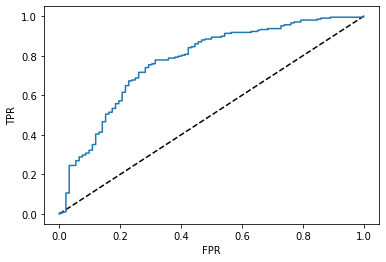

AUC of Test set :  0.7745871655518395
MCC of Test set :  0.40494324888732436


In [99]:
# Create a new SVM classifier for the selected features
SVM_clf_important = svm.SVC(probability=True, C = 1, gamma= 0.1, kernel='rbf', random_state=42)

# Train the new classifier on the new dataset containing the selected features
SVM_clf_important.fit(X_important_train, y)

# Apply The Full Featured Classifier To The Test Data
yy_pred = SVM_clf_important.predict(XX_important)

# View The Accuracy Of Selected Features
print("Accuracy of Test set : ",accuracy_score(yy, yy_pred))
print('-'*100)
      
#  Cross Validation Score
cv_scores = cross_val_score(SVM_clf_important, XX, yy, cv=5)
print("Cross validation - Accuracy of Test set : ", np.mean(cv_scores))
print('-'*100)
      
# Confusion Matrix
cm = confusion_matrix(yy, yy_pred, [1, 0])
print("Confusion Matrix:")
print(cm)
print("Classification Report:")
print(classification_report(yy, yy_pred))
print('-'*100)

# Normalisation Confusion Matrix - Type I and II error
cm = normalize(cm,norm='l1',axis=0)
cm_df = pd.DataFrame(cm, columns=['Good (1)', 'Bad (0)'], index=['Good (1)', 'Bad (0)'])
print("Normalized Confusion Matrix:")
print(cm_df)
print('-'*100)
      
# The ROC Curve
yy_pred_prob = SVM_clf_important.predict_proba(XX_important)[:,1]
fpr, tpr, thresholds = roc_curve(yy, yy_pred_prob)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr,tpr)
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.show()
      
# AUC Area under the roc curve 
print("AUC of Test set : ",roc_auc_score(yy, yy_pred_prob))
      
# Matthews Correlation Coefficient
print("MCC of Test set : ",matthews_corrcoef(yy, yy_pred))

In [0]:
SVMTest = SVM_clf_important.predict(XX_important)
SVM = SVM_clf_important.predict(X_important_train)

## Consensus Model Kohonen’s self-organizing maps (SOM)

In [0]:
# Individual models outcomes (Create training dataset based on result of models)

somDataset = pd.DataFrame ({"LR": LR, "ANN": ANN, "DT": DT, "GBDT": GBDT, "KNN": KNN, "RF": RF, "SVM":SVM})

In [0]:
# Individual models outcomes (Create Test dataset based on result of models)

somTestDataset = pd.DataFrame ({"LR": LRTest, "ANN": ANNTest, "DT": DTTest, "GBDT": GBDTTest,
                                "KNN": KNNTest, "RF": RFTest, "SVM":SVMTest})

In [0]:
# # Grid Search - Hyperparameter Tunning

# param = {"learning_rate_end" : np.arange(0.000001, 0.001), 
#          "learning_rate_start" : np.arange(0.01, 1)}

# clf = susi.SOMClassifier(random_state=42, n_jobs=-1)
# clf_cv = GridSearchCV(clf, param, cv=5) 
# clf_cv.fit(somDataset, y)
# print(clf_cv.best_params_)
# print(clf_cv.best_score_)

# # {'do_class_weighting': False, 'learning_rate_end': 1e-06, 'learning_rate_start': 0.01}

@misc{riese2019susicode,
    author = {Riese, Felix~M.},
    title = {{SuSi: SUpervised Self-organIzing maps in Python}},
    year = {2019},
    DOI = {10.5281/zenodo.2609130},
    publisher = {Zenodo},
    howpublished = {\href{https://doi.org/10.5281/zenodo.2609130}{doi.org/10.5281/zenodo.2609130}}
}

In [104]:
# Create a new SOM classifier 
som = susi.SOMClassifier(n_jobs=-1, random_state=42, learning_rate_end=0.000001, learning_rate_start=0.1)

# Train the new classifier on the new dataset containing the probability of individual models
som.fit(somDataset, y)

SOMClassifier(distance_metric='euclidean', do_class_weighting=True,
              init_mode_supervised='majority', init_mode_unsupervised='random',
              learn_mode_supervised='min', learn_mode_unsupervised='min',
              learning_rate_end=1e-06, learning_rate_start=0.1,
              missing_label_placeholder=None, n_columns=10,
              n_iter_supervised=1000, n_iter_unsupervised=1000, n_jobs=-1,
              n_rows=10, nbh_dist_weight_mode='pseudo-gaussian',
              neighborhood_mode_supervised='linear',
              neighborhood_mode_unsupervised='linear', random_state=42,
              train_mode_supervised='online', train_mode_unsupervised='online',
              verbose=0)

In [105]:
# Train set 
y_train_pred = som.predict(somDataset)

print("Accuracy of Train set : ", accuracy_score(y, y_train_pred))
print('-'*100)

Accuracy of Train set :  0.9028571428571428
----------------------------------------------------------------------------------------------------


In [106]:
# Apply The Classifier To The Test Data
yy_pred = som.predict(somTestDataset)

# Accuracy Of model
print("Accuracy of Test set : ",accuracy_score(yy, yy_pred))
print('-'*100)
            
# Confusion Matrix
cm = confusion_matrix(yy, yy_pred, [1, 0])
print("Confusion Matrix:")
print(cm)
print("Classification Report:")
print(classification_report(yy, yy_pred))
print('-'*100)

# Normalisation Confusion Matrix - Type I and II error
cm = normalize(cm,norm='l1',axis=0)
cm_df = pd.DataFrame(cm, columns=['Good (1)', 'Bad (0)'], index=['Good (1)', 'Bad (0)'])
print("Normalized Confusion Matrix:")
print(cm_df)
print('-'*100)
      
# Matthews Correlation Coefficient
print("MCC of Test set : ",matthews_corrcoef(yy, yy_pred))

Accuracy of Test set :  0.8133333333333334
----------------------------------------------------------------------------------------------------
Confusion Matrix:
[[187  21]
 [ 35  57]]
Classification Report:
              precision    recall  f1-score   support

         0.0       0.73      0.62      0.67        92
         1.0       0.84      0.90      0.87       208

    accuracy                           0.81       300
   macro avg       0.79      0.76      0.77       300
weighted avg       0.81      0.81      0.81       300

----------------------------------------------------------------------------------------------------
Normalized Confusion Matrix:
          Good (1)   Bad (0)
Good (1)  0.842342  0.269231
Bad (0)   0.157658  0.730769
----------------------------------------------------------------------------------------------------
MCC of Test set :  0.5451768247576994


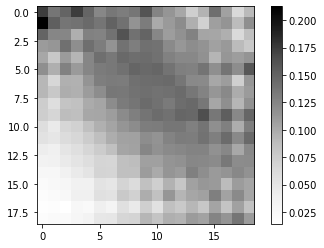

In [107]:
# Plot u-Matrix 

u_matrix = som.get_u_matrix()
plt.imshow(np.squeeze(u_matrix), cmap="Greys")
plt.colorbar()
plt.show()

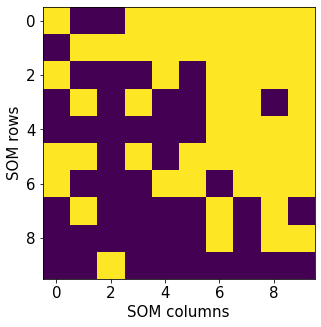

In [108]:
# Plot estimation map

def plot_estimation_map(estimation_map, fontsize=15):
    plt.figure(figsize=(7,5))
    plt.imshow(estimation_map, cmap="viridis_r")
    plt.xlabel("SOM columns", fontsize=fontsize)
    plt.ylabel("SOM rows", fontsize=fontsize)
    plt.xticks(fontsize=fontsize)
    plt.yticks(fontsize=fontsize)
    plt.grid(b=False)

estimation_map = som.get_estimation_map().squeeze()
plot_estimation_map(estimation_map)